This notebook maps electrode channels (the midpoint between two contacts) to hippocmapal surfaces. HippUnfold is run in space-nativepro, which is then registered to space-implant. Distances are calculated between chennel centroids and hippocampal surfaces, and all vertices within 5mm are given that channel bandpower values. 

For a more detailed explanation of code, see `notebooks/iEEG.ipynb`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import nibabel as nib
import glob
import sys
import hippomaps as hm
import pandas as pd
import scipy.io
from scipy.signal import periodogram
import pygeodesic.geodesic as geodesic
from scipy.ndimage import gaussian_filter1d

/export03/data/opt/venv/lib/python3.8/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
micapipe_dir = '/export03/data/publication-hippomaps/sourcedata/Micapipe_MICs'
ieeg_dir = '/host/oncilla/local_raid/iEEG-BIDS' #(no ses)
ieeg_local = '/export03/data/publication-hippomaps/sourcedata/iEEG-local/'
hippunfold_dir = '/data/mica3/BIDS_MICs/derivatives/hippunfold_v1.3.0/hippunfold/'
subs = ['PX001', 'PX005', 'PX007', 'PX009', 
    'PX010', 'PX012', 'PX015', 'PX019', 'PX023', 
    'PX028', 'PX029', 'PX031', 'PX034', 'PX040', 
    'PX041', 'PX045', 'PX050', 'PX051', 'PX053',
    'PX065'] # omit PX004 because previous implant
ses = 'ses-01'
hemis = ['L','R']
labels = ['hipp']#,'dentate'] 
den='2mm'

# get expected number of vertices and their indices
nV,iV = hm.config.get_nVertices(labels,den) 

freq = 200 #Hz
bands = ['delta', 'theta', 'alpha', 'beta', 'gamma']
band_lims = np.array([[0.5,4], [4,8], [8,13], [13,30], [30,80]])
sampspace = np.arange(0.5,80,0.5)
dist_threshold = 5 #mm
colormap = pl.cm.Set1(range(10))

In [3]:
pxx = np.zeros((len(sampspace),0))
cnames = np.zeros((3,0))
for s,sub in enumerate(subs):
    t = scipy.io.loadmat(f'/host/oncilla/local_raid/jessica/microstructure_iEEG/data/ieeg-mni/sub-{sub}_clean_ts.mat')
    f,p = scipy.signal.welch(t['dataclean'])
    for c in range(p.shape[0]):
        n1 = t['dataLabels'][0][c][0].split('-')[0].split(' ')[1]
        n2 = t['dataLabels'][0][c][0].split('-')[1].split(' ')[1]
        cnames = np.concatenate((cnames,np.array((sub,n1,n2)).reshape(-1,1)),axis=1)
        interpolator = scipy.interpolate.interp1d(f*freq,p[c,:]/np.sum(p[c,:]))
        pxx = np.concatenate((pxx,interpolator(sampspace).reshape(-1,1)),axis=1)


In [4]:
pxx.shape

(159, 2507)

(0.4, 100)

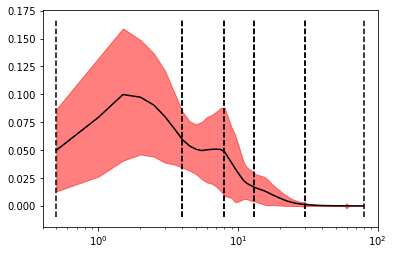

In [5]:
y = np.nanmean(pxx,axis=1)
err = np.nanstd(pxx,axis=1)
plt.plot(sampspace,y,'k-')
plt.fill_between(sampspace, y-err, y+err, alpha=0.5, color='r')
plt.vlines(band_lims.flatten(),plt.gca().get_ylim()[0],plt.gca().get_ylim()[1],colors='k',linestyles='--')
plt.xscale('log')
plt.xlim(0.4,100)

In [6]:
bp = np.zeros((pxx.shape[1], len(bands)))
for b in range(len(bands)):
    for c in range(pxx.shape[1]):
        mask = np.logical_and(sampspace>band_lims[b,0], sampspace<band_lims[b,1])
        bp[c,b] = np.trapz(pxx[mask,c],sampspace[mask])

/data/mica1/01_programs/tmp/ipykernel_11684/1080293335.py:19: UserWarning: Legend does not support <AxesSubplot:> instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend(handles=ax[1:])


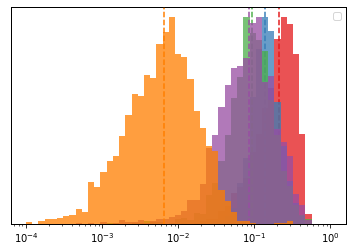

In [7]:
color_discrete = pl.cm.Set1(range(10))
l=['delta', 'theta', 'alpha', 'beta', 'gamma']
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.yaxis.set_visible(False)
ax = [ax]
n=0
cbins = []
for b in range(5):
    ax = ax + [ax[0].twinx()]
    dat = bp[:,b]
    plt.axvline(x=np.nanmedian(dat), color=color_discrete[n], linestyle='dashed')
    ax[n+1].hist(dat,bins=np.logspace(np.log10(1e-4),np.log10(1), 50), linestyle=None, alpha=0.5, 
               color=color_discrete[b], label=l[b]);
    cbins.append(ax[n+1].hist(dat,bins=np.logspace(np.log10(1e-4),np.log10(1), 50), linestyle=None, alpha=0.5, 
               color=colormap[b], label=l[b]))
    ax[n+1].yaxis.set_visible(False)
    n=n+1
plt.legend(handles=ax[1:])

## Localization
Here, we have the vertices associated with each channel that falls within 5mm of the hippocampus. 

In [8]:
# Register hippunfold surfaces to implant space
for s,sub in enumerate(subs):
    cmd1 = f'antsRegistrationSyNQuick.sh -d 3 -t r '\
    f'-m {micapipe_dir}/sub-{sub}/{ses}/anat/sub-{sub}_{ses}_space-nativepro_t1w.nii.gz '\
    f'-f {ieeg_dir}/sub-{sub}/anat/sub-{sub}_implanted.nii '\
    f'-o {ieeg_dir}/sub-{sub}/xfms/sub-{sub}_{ses}_space-nativepro-to-implanted_desc-rigid_'
    if not glob.glob(f'{ieeg_dir}/sub-{sub}/xfms/sub-{sub}_{ses}_space-nativepro-to-implanted_desc-rigid_0GenericAffine.mat'):
        !{cmd1}
    cmd2 = f'c3d_affine_tool '\
        f'-itk {ieeg_dir}/sub-{sub}/xfms/sub-{sub}_{ses}_space-nativepro-to-implanted_desc-rigid_0GenericAffine.mat '\
        f'-inv '\
        f'-o {ieeg_dir}/sub-{sub}/xfms/sub-{sub}_{ses}_space-nativepro-to-implanted_desc-rigid_0GenericAffine.txt'
    if not glob.glob(f'{ieeg_dir}/sub-{sub}/xfms/sub-{sub}_{ses}_space-nativepro-to-implanted_desc-rigid_0GenericAffine.txt'):
        !{cmd2}
    for h,hemi in enumerate(hemis):
        for l,label in enumerate(labels):    
            cmd3 = f'wb_command -surface-apply-affine '\
            f'{hippunfold_dir}/sub-{sub}/{ses}/surf/sub-{sub}_{ses}_hemi-{hemi}_space-T1w_den-{den}_label-{label}_midthickness.surf.gii '\
            f'{ieeg_dir}/sub-{sub}/xfms/sub-{sub}_{ses}_space-nativepro-to-implanted_desc-rigid_0GenericAffine.txt '\
            f'{ieeg_dir}/sub-{sub}/tmp/sub-{sub}_{ses}_hemi-{hemi}_space-implant_den-{den}_label-{label}_midthickness.surf.gii'
            if not glob.glob(f'{ieeg_dir}/sub-{sub}/tmp/sub-{sub}_{ses}_hemi-{hemi}_space-implant_den-{den}_label-{label}_midthickness.surf.gii'):
                !{cmd3}


In [9]:
def insensitive_glob(pattern):
    def either(c):
        return '[%s%s]' % (c.lower(), c.upper()) if c.isalpha() else c
    return glob.glob(''.join(map(either, pattern)))

In [10]:
change_table = {'filenames': ['sub-PX015/anat/electrode_LOTj.csv',
                                 'sub-PX028/anat/electrode_LHa.csv',
                                 'sub-PX028/anat/electrode_RFug.csv',
                                 'sub-PX031/anat/electrode_LA.csv',
                                 'sub-PX045/anat/electrode_LEC.csv',
                                 'sub-PX065/anat/electrode_RCP.csv',
                                 'sub-PX065/anat/electrode_RPt.csv'],
               'electrodenames': ['LTOJ',
                                 'LH',
                                 'RFus',
                                 'LIa',
                                 'LE',
                                 'RPC',
                                 'RTp']}

In [11]:
hipp_bp = np.ones([nV,2,5,pxx.shape[1]])*np.nan
hipp_pxx = np.ones([nV,2,len(sampspace),pxx.shape[1]])*np.nan
missing_electrodes = []
label='hipp'
for h,hemi in enumerate(hemis):
    for c in range(pxx.shape[1]):
        sub = cnames[0,c]
        surf = nib.load(f'{ieeg_dir}/sub-{sub}/tmp/sub-{sub}_{ses}_hemi-{hemi}_space-implant_den-{den}_label-{label}_midthickness.surf.gii')
        vertices = surf.get_arrays_from_intent('NIFTI_INTENT_POINTSET')[0].data
        ename = ''.join([i for i in cnames[1,c] if not i.isdigit()])
        electrode = insensitive_glob(f'{ieeg_dir}/sub-{sub}/anat/electrode_{ename}.csv')
        ## this block sucks but we need to rename some electrodes
        if f'sub-{sub}/anat/electrode_{ename}.csv' in change_table['filenames']:
            i = change_table['filenames'].index(f'sub-{sub}/anat/electrode_{ename}.csv')
            ename = change_table['electrodenames'][i]
            enum = ''.join([i for i in cnames[1,c] if i.isdigit()])
            cnames[1,c] = ename+enum
            enum = ''.join([i for i in cnames[2,c] if i.isdigit()])
            cnames[2,c] = ename+enum
            electrode = insensitive_glob(f'{ieeg_dir}/sub-{sub}/anat/electrode_{ename}.csv')
        ## end sucky block
        if electrode:
            try:
                file = open(electrode[0],'r')
                for line in file.readlines():
                    if f'[contact],{cnames[1,c]}' in line:
                        xyz1 = line.split(',')[3:6]
                    elif f'[contact],{cnames[2,c]}' in line:
                        xyz2 = line.split(',')[3:6]
                file.close()
                xyz = (np.asarray(xyz1, dtype=float)+np.asarray(xyz2, dtype=float))/2
                for v in range(len(vertices)):
                    dist = np.linalg.norm(xyz-vertices[v,:])
                    if dist <= dist_threshold:
                        hipp_bp[v,h,:,c] = bp[c,:]
                        hipp_pxx[v,h,:,c] = pxx[:,c]
            except:
                print(f'sub-{sub}/anat/electrode_{ename}.csv contact {cnames[1,c]} and {cnames[2,c]} not found at {c}')
        else:
            missing_electrodes.append(f'sub-{sub}/anat/electrode_{ename}.csv')
set(missing_electrodes)

set()

In [12]:
hipp_pxx.shape

(419, 2, 159, 2507)

In [13]:
hipp_bp.shape

(419, 2, 5, 2507)

In [14]:
print('number of L hemis: ' + str(len(np.where(np.any(~np.isnan(hipp_bp[:,0,0,:]),axis=0))[0])))
print('number of R hemis: ' + str(len(np.where(np.any(~np.isnan(hipp_bp[:,1,0,:]),axis=0))[0])))

number of L hemis: 7
number of R hemis: 37


/export03/data/opt/BrainSpace/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


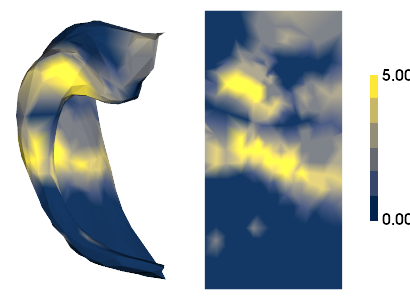

In [15]:
hipp_bp_count = np.sum(~np.isnan(hipp_bp),axis=(1,3))[:,0]
hm.plotting.surfplot_canonical_foldunfold(hipp_bp_count, den='2mm', hemis=['L'], labels=labels, unfoldAPrescale=True, tighten_cwindow=True, cmap='cividis', share='row', color_bar='right', embed_nb=True)

(0.4, 100)

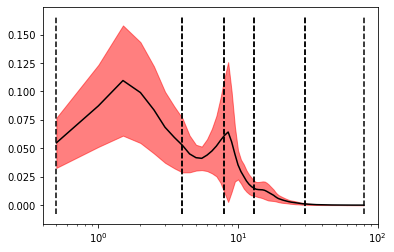

In [16]:
y = np.nanmean(hipp_pxx,axis=(0,1,3))
err = np.nanstd(hipp_pxx,axis=(0,1,3))
plt.plot(sampspace,y,'k-')
plt.fill_between(sampspace, y-err, y+err, alpha=0.5, color='r')
plt.vlines(band_lims.flatten(),plt.gca().get_ylim()[0],plt.gca().get_ylim()[1],colors='k',linestyles='--')
plt.xscale('log')
plt.xlim(0.4,100)

(0.4, 100)

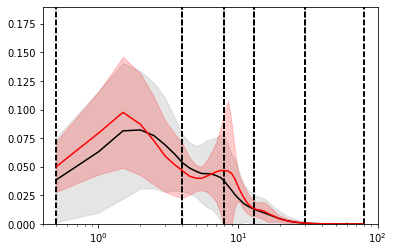

In [17]:
y = np.exp(np.nanmean(np.log(pxx),axis=1))
err = np.nanstd(pxx,axis=1)
plt.plot(sampspace,y,'k')
plt.ylim(0,.19)
plt.fill_between(sampspace, y-err, y+err, alpha=0.2, color='gray')
plt.vlines(band_lims.flatten(),plt.gca().get_ylim()[0],plt.gca().get_ylim()[1],colors='k',linestyles='--')
plt.xscale('log')
plt.xlim(0.4,100)

y = np.exp(np.nanmean(np.log(hipp_pxx),axis=(0,1,3)))
err = np.nanstd(hipp_pxx,axis=(0,1,3))
plt.plot(sampspace,y,'r')
plt.ylim(0,.19)
plt.fill_between(sampspace, y-err, y+err, alpha=0.2, color='r')
plt.vlines(band_lims.flatten(),plt.gca().get_ylim()[0],plt.gca().get_ylim()[1],colors='k',linestyles='--')
plt.xscale('log')
plt.xlim(0.4,100)

/data/mica1/01_programs/tmp/ipykernel_11684/773083350.py:19: UserWarning: Legend does not support <AxesSubplot:> instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend(handles=ax[1:])


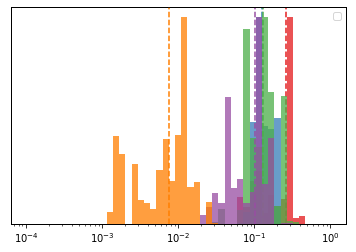

In [18]:
color_discrete = plt.cm.Set1(range(10))
l=['delta', 'theta', 'alpha', 'beta', 'gamma']
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.yaxis.set_visible(False)
ax = [ax]
n=0
hippcbins = [] # number of channels in each bin
for b in range(5):
    ax = ax + [ax[0].twinx()]
    dat = hipp_bp[:,:,b,:].flatten()
    plt.axvline(x=np.nanmedian(dat), color=color_discrete[n], linestyle='dashed')
    ax[n+1].hist(dat,bins=np.logspace(np.log10(1e-4),np.log10(1), 50), linestyle=None, alpha=0.5, 
               color=color_discrete[b], label=l[b]);
    hippcbins.append(ax[n+1].hist(dat,bins=np.logspace(np.log10(1e-4),np.log10(1), 50), linestyle=None, alpha=0.5, 
               color=colormap[b], label=l[b]))
    ax[n+1].yaxis.set_visible(False)
    n=n+1
plt.legend(handles=ax[1:])

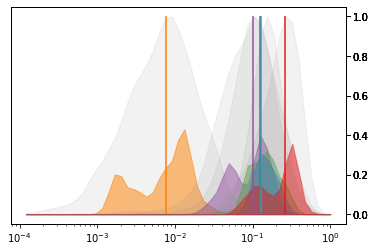

In [19]:
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.yaxis.set_visible(False)
ax = [ax]
sigma = 1
n=0
for b in reversed(range(5)):
    ax = ax + [ax[0].twinx()]
    dat = bp[:,b]
    #ax[n+1].vlines(np.nanmedian(dat),0,1, color='gray', linestyle='dashed')
    plt.fill_between(cbins[b][1][1:],gaussian_filter1d(cbins[b][0],sigma), color='gray', alpha=0.1)
    ax[n+1].yaxis.set_visible(False)
    n=n+1
n=0
for b in reversed(range(5)):
    ax = ax + [ax[0].twinx()]
    dat = hipp_bp[:,:,b,:].flatten()
    plt.vlines(np.nanmedian(dat),0,1, color=colormap[b], linestyle='solid')
    ax[n+1].fill_between(hippcbins[b][1][1:],gaussian_filter1d(hippcbins[b][0],sigma), color=colormap[b], alpha=0.5)
    #ax[n+1].hist(dat,bins=np.logspace(np.log10(1e-4),np.log10(1), 50), linestyle=None, alpha=0.5, 
    #           color=colormap[b], label=l[b]);
    ax[n+1].yaxis.set_visible(False)
    n=n+1

## Extrapolation
We can see that simply averaging over all channels doesn't give a good idea of the spatial distribution of band power, since so much data is missing. Thus, we will extrapolate each channel over the whole hippocampus and then use the distance from the channel as a weighting when performing weighted averaging across channels. See `../extras` for an example visualization.

In [21]:
gii = nib.load(f'../../resources/canonical_surfs/tpl-avg_space-canonical_den-{den}_label-hipp_midthickness.surf.gii')
v = gii.get_arrays_from_intent('NIFTI_INTENT_POINTSET')[0].data
f = gii.get_arrays_from_intent('NIFTI_INTENT_TRIANGLE')[0].data
gii = nib.load(f'../../resources/canonical_surfs/tpl-avg_space-canonical_den-{den}_label-dentate_midthickness.surf.gii')
vdg = gii.get_arrays_from_intent('NIFTI_INTENT_POINTSET')[0].data
fdg = gii.get_arrays_from_intent('NIFTI_INTENT_TRIANGLE')[0].data
F = [f, fdg]
V = [v, vdg]

In [22]:
# cominbing BP across channels and vertices for visualization
# here, we exctrapoalte the data from any channel across the entire hippocampus, and then average across all channels. However, the average across channels is weighted by distance to the actual channel contact. 

weights_hipp_bp = np.ones((hipp_bp.shape[0],2,hipp_bp.shape[3]))*np.nan
interp_hipp_bp = np.zeros([hipp_bp.shape[0],5])
interp_hipp_perio_dat = np.zeros([hipp_bp.shape[0],len(pxx)])

for h,hemis in enumerate(hemis):
    for c in range(hipp_bp.shape[3]):
        for l,label in enumerate(labels):
            mask = ~np.isnan(hipp_bp[iV[l],h,0,c])
            if np.any(mask):
                geoalg = geodesic.PyGeodesicAlgorithmExact(V[l], F[l])
                sd,_ = geoalg.geodesicDistances(np.where(mask)[0], None)
                sd = sd**2
                weights_hipp_bp[iV[l],h,c] = 1 - (sd/np.max(sd))
totweights = np.nansum(weights_hipp_bp, axis=(1,2))
for v in range(weights_hipp_bp.shape[0]):
    for h,hemis in enumerate(hemis):
        for c in range(hipp_bp.shape[3]):
            w = weights_hipp_bp[v,h,c] / totweights[v]
            if w>0:
                interp_hipp_bp[v,:] += np.nanmean(hipp_bp[:,h,:,c],axis=0) * w
                interp_hipp_perio_dat[v,:] += np.nanmean(hipp_pxx[:,h,:,c],axis=0) * w

/export03/data/opt/BrainSpace/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


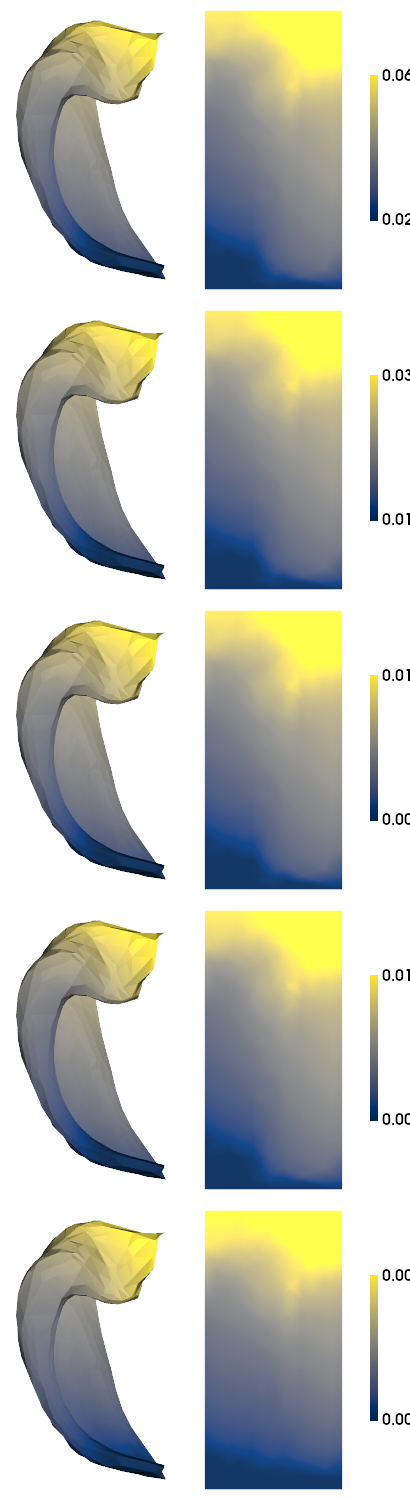

In [23]:
hm.plotting.surfplot_canonical_foldunfold(interp_hipp_bp, den=den, hemis=['L'], labels=labels, unfoldAPrescale=True, tighten_cwindow=True, cmap='cividis', share='row', color_bar='right', embed_nb=True)

## example of how data gets extrapolated along a geodesic distance

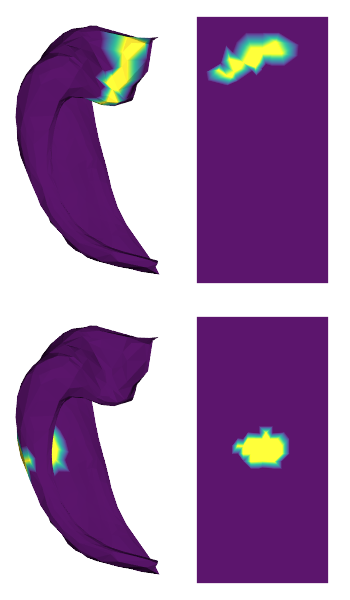

In [24]:
import copy
hd = copy.deepcopy(hipp_bp)
wd = copy.deepcopy(weights_hipp_bp)
hd[np.isnan(hd)] = 0
wd[np.isnan(wd)] = 0

h=1
c=[1201,1635]
hm.plotting.surfplot_canonical_foldunfold(hd[:,h,b,c], hemis=['L'], labels=labels, den=den, embed_nb=True)

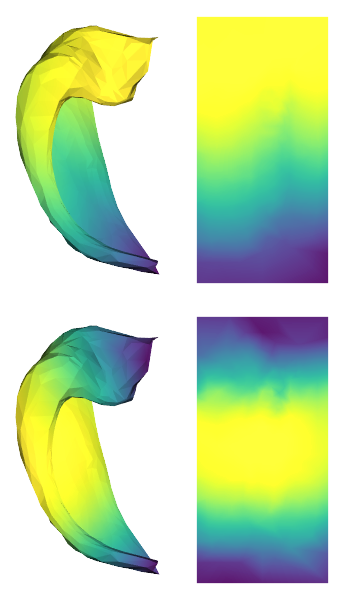

In [25]:
hm.plotting.surfplot_canonical_foldunfold(wd[:,h,c], hemis=['L'], labels=labels, den=den, embed_nb=True)

## Brainspace gradients

In [26]:
from brainspace.gradient import GradientMaps
# gradient decomposition
bpgm = GradientMaps(n_components=5, kernel='normalized_angle')
bpgm.fit(interp_hipp_perio_dat)

/export03/data/opt/BrainSpace/brainspace/gradient/kernels.py:29: RuntimeWarning: invalid value encountered in arccos
  x = 1 - np.arccos(x, x)/np.pi


ValueError: Affinity matrix contains NaN or Inf values. Common causes of this include NaNs/Infs or rows of zeros in the input matrix.

In [27]:
hm.plotting.surfplot_canonical_foldunfold(bpgm.gradients_, den=den, hemis=['L'], labels=labels, unfoldAPrescale=True, tighten_cwindow=True, cmap='plasma', share='row', color_bar='right', embed_nb=True)

AttributeError: 'NoneType' object has no attribute 'shape'

ValueError: x, y, and format string must not be None

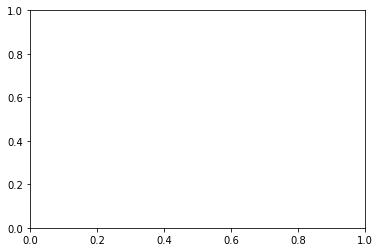

In [28]:
plt.plot(bpgm.lambdas_)

In [29]:
vars_to_load = [pxx, bp, hipp_bp, hipp_pxx]
np.save(f'../checkpoints/iEEG_MICs_dat', vars_to_load, allow_pickle=True,)

/export03/data/opt/venv/lib/python3.8/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)
